# Red Wine Quality Prediction

## Project Goal

The goal of this project is to determine which features of red wine variants of the Portuguese "Vinho Verde" wines contribute to the quality of a good wine and apply a model to predict the quality of a Portuguese "Vinho Verde" wine.

More information and related data can be found here:  https://www.kaggle.com/ucim/red-wine-quality-cortez-et-al-2009 .

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import math

import pickle

%matplotlib inline

## Functions

In [2]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [3]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [4]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

## Data Dictionary

#### *fixed acidity*
most acids involved with wine or fixed or nonvolatile (do not evaporate readily).
#### *volatile acidity*
the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
#### *citric acid*
found in small quantities, citric acid can add 'freshness' and flavor to wines.
#### *residual sugar*
the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.
#### *chlorides*
the amount of salt in the wine.
#### *free sulfur dioxide*
the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
#### *total sulfur dioxide*
amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
#### *density*
the density of wine is close to that of water depending on the percent alcohol and sugar content.
#### *pH*
describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
#### *sulphates*
a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.
#### *alcohol*
the percent alcohol content of the wine.
#### *quality*
output variable (based on sensory data, score between 0 and 10).

## Load the Data

In [5]:
df = pd.read_csv('winequality-red.csv', delimiter=';', index_col=False)

In [6]:
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
453,10.4,0.33,0.63,2.8,0.084,5.0,22.0,0.99980,3.26,0.74,11.2,7
334,7.9,0.65,0.01,2.5,0.078,17.0,38.0,0.99630,3.34,0.74,11.7,7
66,7.5,0.52,0.11,1.5,0.079,11.0,39.0,0.99680,3.42,0.58,9.6,5
1435,10.2,0.54,0.37,15.4,0.214,55.0,95.0,1.00369,3.18,0.77,9.0,6
541,9.5,0.46,0.49,6.3,0.064,5.0,17.0,0.99880,3.21,0.73,11.0,6


## Pre-process and Clean the Data

#### Data Shape

In [7]:
df.shape

(1599, 12)

#### Null Values?

In [8]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### Column Info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [10]:
# lowercase all column names
df.columns = df.columns.str.lower()

#### Data Statistics

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
ph,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


This data has no missing values and is all numeric data.  All column names have been lowercased.

## Exploratory Data Analysis

Our target feature is **quality**.  We will take a loo at how its values are distributed and how other features correlate.

#### Distribution of Counts

<AxesSubplot:xlabel='quality', ylabel='count'>

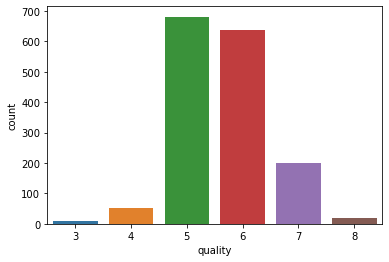

In [12]:
sns.countplot(x=df['quality'])

#### Unique Value counts for Target Column

In [15]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Most wines in this dataset have a quality value of 5 or 6.

### Correlations

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

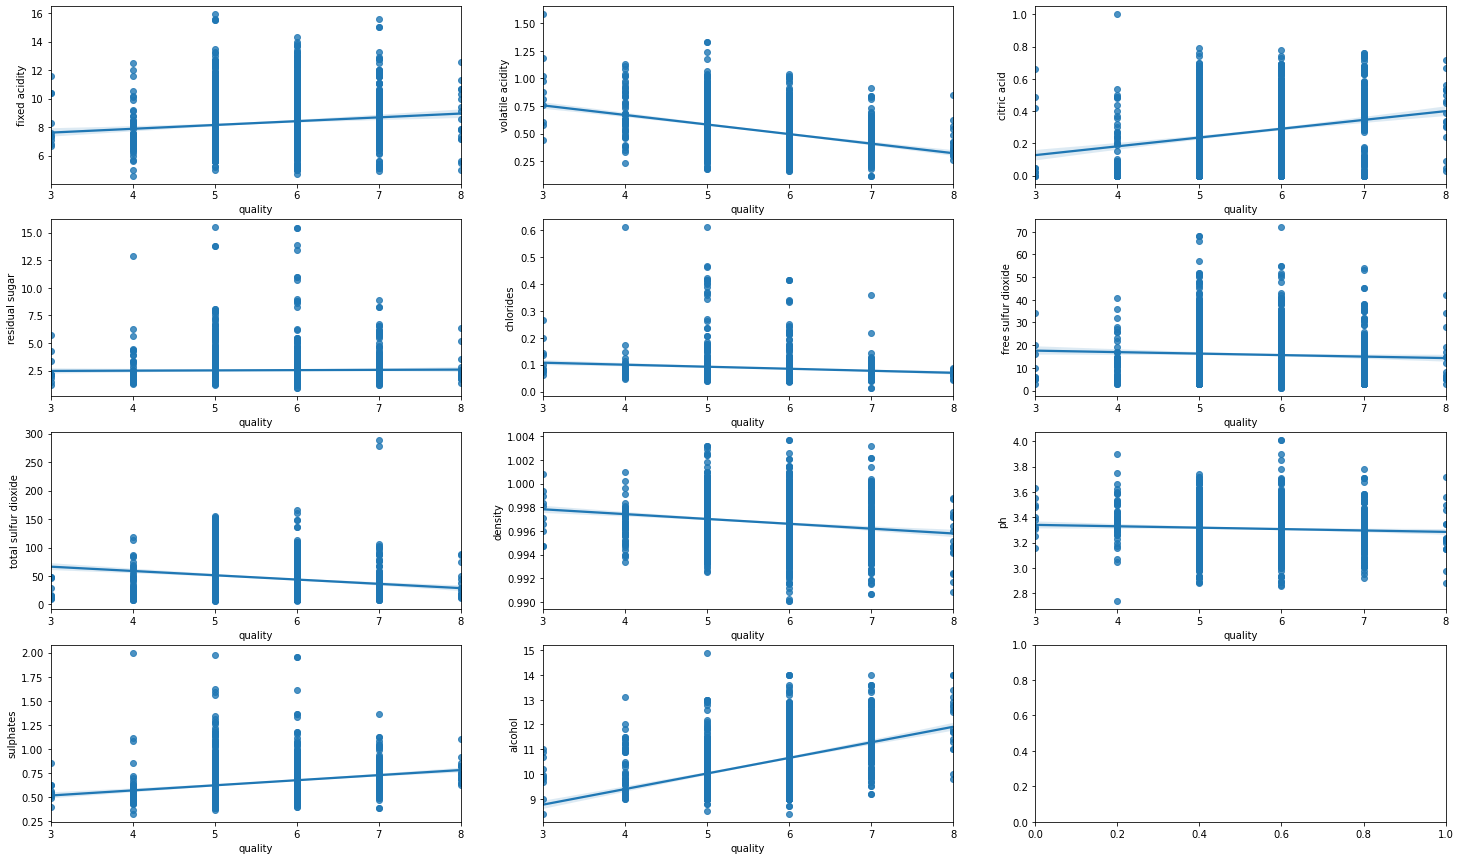

In [16]:
f, x = plt.subplots(4, 3, figsize=(25,15))
sns.regplot(x = df['quality'], y = df['fixed acidity'], ax = x[0, 0])
sns.regplot(x = df['quality'], y = df['volatile acidity'], ax = x[0, 1])
sns.regplot(x = df['quality'], y = df['citric acid'], ax = x[0, 2])
sns.regplot(x = df['quality'], y = df['residual sugar'], ax = x[1, 0])
sns.regplot(x = df['quality'], y = df['chlorides'], ax = x[1, 1])
sns.regplot(x = df['quality'], y = df['free sulfur dioxide'], ax = x[1, 2])
sns.regplot(x = df['quality'], y = df['total sulfur dioxide'], ax = x[2, 0])
sns.regplot(x = df['quality'], y = df['density'], ax = x[2, 1])
sns.regplot(x = df['quality'], y = df['ph'], ax = x[2, 2])
sns.regplot(x = df['quality'], y = df['sulphates'], ax = x[3, 0])
sns.regplot(x = df['quality'], y = df['alcohol'], ax = x[3, 1])

In [17]:
corr = pd.DataFrame(columns=["Feature", "Correlation to Quality"])
corr = df.corr()['quality'].sort_values(ascending=False)
corr

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
ph                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

In [18]:
abs(corr) > 0.2

quality                  True
alcohol                  True
sulphates                True
citric acid              True
fixed acidity           False
residual sugar          False
free sulfur dioxide     False
ph                      False
chlorides               False
density                 False
total sulfur dioxide    False
volatile acidity         True
Name: quality, dtype: bool

There is a strong positive correlation between the percentage of alcohol in the wine and the quality of the wine.
There is a strong negative correlation between the amount of acetic acid in wine and the quality of the wine.  This makes sense because too high levels of acetic acid will give the wine an  unpleasant, vinegar taste.  There are also positive correlations with sulphates and citric acid, and the quality of the wine.  We can take a closer look at these correlated features.

#### Alcohol

[Text(0.5, 1.0, 'Alcohol')]

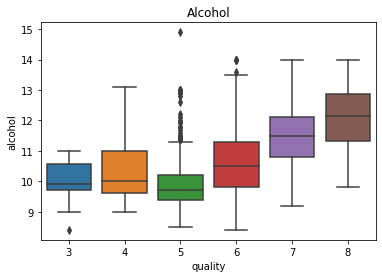

In [19]:
box_plot = sns.boxplot(x='quality', y='alcohol', data=df)
box_plot.set(title="Alcohol")

We can see the higher the percentage of alcohol contents in the wine, the higher the quality of the wine.

[Text(0.5, 1.0, 'Sulphates')]

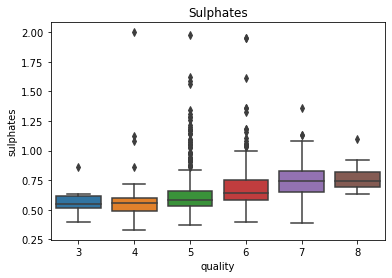

In [20]:
box_plot = sns.boxplot(x='quality', y='sulphates', data=df)
box_plot.set(title="Sulphates")

[Text(0.5, 1.0, 'Citric Acid')]

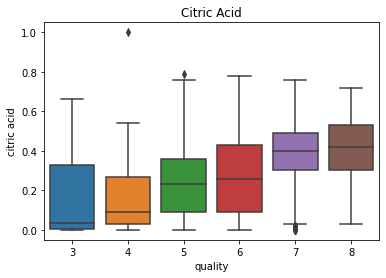

In [21]:
box_plot = sns.boxplot(x='quality', y='citric acid', data=df)
box_plot.set(title="Citric Acid")

The higher the citric acid and sulfates, the higher the quality.

[Text(0.5, 1.0, 'Volatile Acidity')]

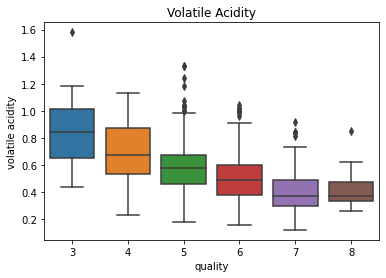

In [22]:
box_plot = sns.boxplot(x='quality', y='volatile acidity', data=df)
box_plot.set(title="Volatile Acidity")

There is definitely a negative correlation between volatile acidity and quality.

In [23]:
corr_features = ['alcohol', 'sulphates', 'citric acid', 'volatile acidity', 'quality']
corr_features

['alcohol', 'sulphates', 'citric acid', 'volatile acidity', 'quality']

In [24]:
df_corr = df[corr_features]
df_corr

,alcohol,sulphates,citric acid,volatile acidity,quality
0,9.4,0.56,0.00,0.700,5
1,9.8,0.68,0.00,0.880,5
2,9.8,0.65,0.04,0.760,5
3,9.8,0.58,0.56,0.280,6
4,9.4,0.56,0.00,0.700,5
...,...,...,...,...,...
1594,10.5,0.58,0.08,0.600,5
1595,11.2,0.76,0.10,0.550,6
1596,11.0,0.75,0.13,0.510,6
1597,10.2,0.71,0.12,0.645,5


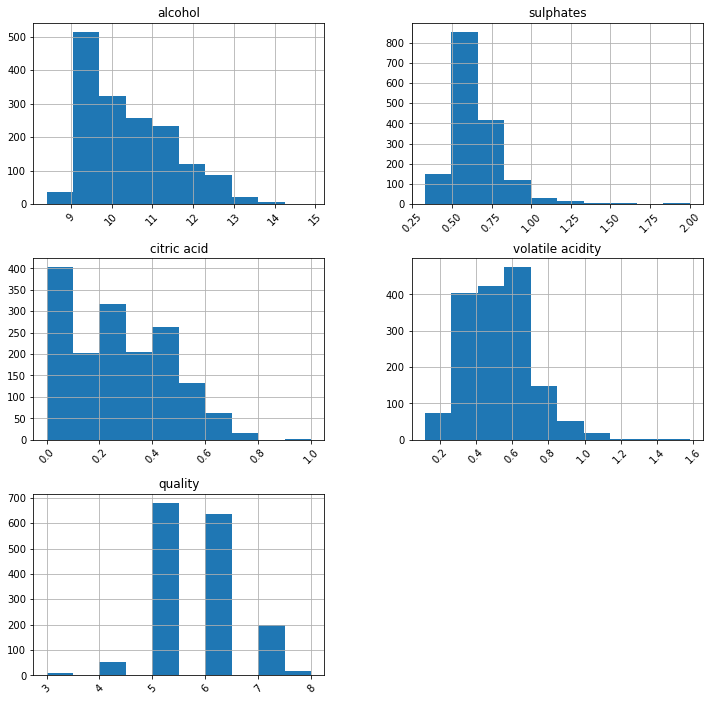

In [25]:
df_corr.hist(figsize=(12,12), xrot=45)
plt.show()

### Split the Data

In [26]:
df_full_train, df_test = train_test_split(df_corr, test_size=0.2, shuffle=True, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle=True, random_state=1)

In [27]:
print(f'Train Data: {round(df_train.shape[0]/df.shape[0],2)*100}%; Validation Data: {round(df_val.shape[0]/df.shape[0],2)*100}%; Test Data: {round(df_test.shape[0]/df.shape[0],2)*100}%')

Train Data: 60.0%; Validation Data: 20.0%; Test Data: 20.0%


In [28]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [29]:
y_full_train = df_full_train.quality.values
y_train = df_train.quality.values
y_val = df_val.quality.values
y_test = df_test.quality.values

In [30]:
del df_full_train['quality']
del df_train['quality']
del df_val['quality']
del df_test['quality']

## Train the Models

In [31]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [32]:
models = {
    "Linear Regression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

In [33]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " Score: {:.5}".format(model.score(X_val, y_val)))

Linear Regression Score: 0.32334
DecisionTree Score: 0.059166
Random Forest Score: 0.43821
XGBoost Score: 0.33946


### Linear Regression

In [34]:
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.6603178967920652

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_val = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred_val)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(lr.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

MSE: 0.43602
Score: 0.32334
RMSE: 0.66032


In [36]:
y_pred_val = np.round(y_pred_val)
confusion = confusion_matrix(y_val, y_pred_val)
confusion

array([[ 0,  0,  3,  0,  0,  0],
       [ 0,  0,  9,  3,  0,  0],
       [ 0,  1, 84, 59,  0,  0],
       [ 0,  0, 39, 79,  4,  0],
       [ 0,  0,  0, 33,  4,  0],
       [ 0,  0,  0,  0,  2,  0]], dtype=int64)

In [37]:
class_rpt = classification_report(y_test, y_pred_val)
print(f"Classification Report: \n{class_rpt}")

Classification Report: 
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       0.41      0.40      0.41       140
           6       0.43      0.55      0.48       134
           7       0.00      0.00      0.00        30
           8       0.00      0.00      0.00         2

    accuracy                           0.41       320
   macro avg       0.14      0.16      0.15       320
weighted avg       0.36      0.41      0.38       320



C:\Users\sasco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)
    

0.0 2.7337862087914004 0.6603178967920652
1e-05 2.7337816595018922 0.6603178932211298
0.0001 2.7337407166223873 0.6603178610929296
0.001 2.733331359785126 0.6603175408262326
0.1 2.6890867909908334 0.6602932040867415
1 2.347379085122005 0.6607921779767361
10 1.083585956812278 0.6735584345571851


### Decision Tree

In [39]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_val = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(dt.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

MSE: 0.64062
Score: 0.0058196
RMSE: 0.80039


In [40]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- alcohol <= 10.45
|   |--- sulphates <= 0.57
|   |   |--- volatile acidity <= 0.79
|   |   |   |--- citric acid <= 0.31
|   |   |   |   |--- sulphates <= 0.53
|   |   |   |   |   |--- alcohol <= 9.08
|   |   |   |   |   |   |--- sulphates <= 0.51
|   |   |   |   |   |   |   |--- value: [4.00]
|   |   |   |   |   |   |--- sulphates >  0.51
|   |   |   |   |   |   |   |--- value: [5.00]
|   |   |   |   |   |--- alcohol >  9.08
|   |   |   |   |   |   |--- citric acid <= 0.20
|   |   |   |   |   |   |   |--- citric acid <= 0.18
|   |   |   |   |   |   |   |   |--- volatile acidity <= 0.75
|   |   |   |   |   |   |   |   |   |--- alcohol <= 9.65
|   |   |   |   |   |   |   |   |   |   |--- citric acid <= 0.09
|   |   |   |   |   |   |   |   |   |   |   |--- value: [5.00]
|   |   |   |   |   |   |   |   |   |   |--- citric acid >  0.09
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- alcohol >  9.65
|   |   |   |   |  

<function matplotlib.pyplot.show(close=None, block=None)>

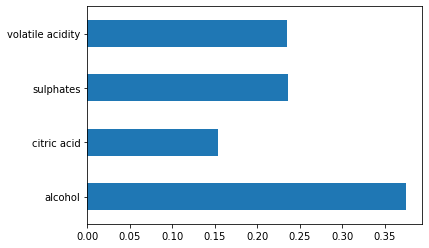

In [41]:
feature_importances = pd.Series(dt.feature_importances_, index=dv.get_feature_names())
feature_importances.plot(kind='barh')
plt.show

C:\Users\sasco\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

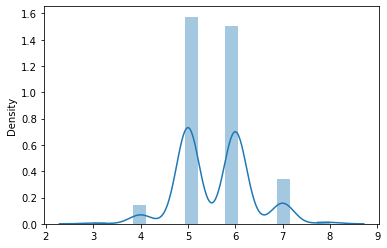

In [42]:
sns.distplot(y_test)

C:\Users\sasco\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

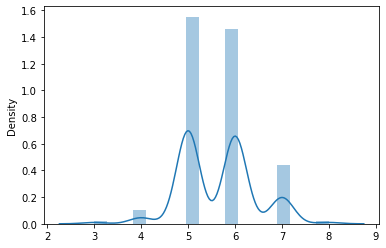

In [43]:
sns.distplot(y_pred_val)

In [44]:
y_pred_val = np.round(y_pred_val)
confusion = confusion_matrix(y_val, y_pred_val)
confusion

array([[ 0,  0,  2,  1,  0,  0],
       [ 1,  1,  6,  4,  0,  0],
       [ 1,  5, 91, 42,  5,  0],
       [ 0,  3, 39, 64, 15,  1],
       [ 0,  0,  0, 18, 18,  1],
       [ 0,  0,  0,  1,  1,  0]], dtype=int64)

In [45]:
class_rpt = classification_report(y_test, y_pred_val)
print(f"Classification Report: \n{class_rpt}")

Classification Report: 
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.11      0.08      0.09        13
           5       0.46      0.46      0.46       140
           6       0.46      0.45      0.45       134
           7       0.05      0.07      0.06        30
           8       0.00      0.00      0.00         2

    accuracy                           0.40       320
   macro avg       0.18      0.17      0.18       320
weighted avg       0.41      0.40      0.40       320



In [46]:
scores = []

for depth in [None, 2, 3, 4]:
    for s in [1, 5, 10, 15, 20, 500, 1000, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        
        scores.append((depth, s, rmse))

columns = ['max_depth', 'min_samples_leaf', 'rmse']
dt_scores = pd.DataFrame(scores, columns=columns)     

dt_scores_pivot = dt_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse'])
dt_scores_pivot.round(3)

rmse                     
max_depth           NaN    2.0    3.0    4.0
min_samples_leaf                            
1                 0.766  0.729  0.684  0.674
5                 0.680  0.729  0.684  0.674
10                0.679  0.729  0.684  0.680
15                0.685  0.729  0.684  0.680
20                0.698  0.729  0.686  0.685
100               0.687  0.729  0.690  0.687
200               0.740  0.740  0.740  0.740
500               0.809  0.809  0.809  0.809
1000              0.809  0.809  0.809  0.809

In [47]:
dt_parameters = {
    'max_depth': [1,3,5,7,9,11,12],
    'min_samples_leaf': [1, 5, 10, 15, 20, 500, 1000, 100, 200]}


In [48]:
tuning_model = GridSearchCV(dt, param_grid=dt_parameters, scoring='neg_mean_squared_error', cv=5, verbose=4)

In [49]:
tuning_model.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV 1/5] END ................max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV 2/5] END ................max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV 3/5] END ................max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV 4/5] END ................max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV 5/5] END ................max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV 1/5] END ................max_depth=1, min_samples_leaf=5; total time=   0.0s
[CV 2/5] END ................max_depth=1, min_samples_leaf=5; total time=   0.0s
[CV 3/5] END ................max_depth=1, min_samples_leaf=5; total time=   0.0s
[CV 4/5] END ................max_depth=1, min_samples_leaf=5; total time=   0.0s
[CV 5/5] END ................max_depth=1, min_samples_leaf=5; total time=   0.0s
[CV 1/5] END ...............max_depth=1, min_samples_leaf=10; total time=   0.0s
[CV 2/5] END ...............max_depth=1, min_sa

[CV 3/5] END ..............max_depth=5, min_samples_leaf=100; total time=   0.0s
[CV 4/5] END ..............max_depth=5, min_samples_leaf=100; total time=   0.0s
[CV 5/5] END ..............max_depth=5, min_samples_leaf=100; total time=   0.0s
[CV 1/5] END ..............max_depth=5, min_samples_leaf=200; total time=   0.0s
[CV 2/5] END ..............max_depth=5, min_samples_leaf=200; total time=   0.0s
[CV 3/5] END ..............max_depth=5, min_samples_leaf=200; total time=   0.0s
[CV 4/5] END ..............max_depth=5, min_samples_leaf=200; total time=   0.0s
[CV 5/5] END ..............max_depth=5, min_samples_leaf=200; total time=   0.0s
[CV 1/5] END ................max_depth=7, min_samples_leaf=1; total time=   0.0s
[CV 2/5] END ................max_depth=7, min_samples_leaf=1; total time=   0.0s
[CV 3/5] END ................max_depth=7, min_samples_leaf=1; total time=   0.0s
[CV 4/5] END ................max_depth=7, min_samples_leaf=1; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END ...............max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV 2/5] END ...............max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV 3/5] END ...............max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV 4/5] END ...............max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV 5/5] END ...............max_depth=11, min_samples_leaf=5; total time=   0.0s
[CV 1/5] END ..............max_depth=11, min_samples_leaf=10; total time=   0.0s
[CV 2/5] END ..............max_depth=11, min_samples_leaf=10; total time=   0.0s
[CV 3/5] END ..............max_depth=11, min_samples_leaf=10; total time=   0.0s
[CV 4/5] END ..............max_depth=11, min_samples_leaf=10; total time=   0.0s
[CV 5/5] END ..............max_depth=11, min_samples_leaf=10; total time=   0.0s
[CV 1/5] END ..............max_depth=11, min_samples_leaf=15; total time=   0.0s
[CV 2/5] END ..............max_depth=11, min_samples_leaf=15; total time=   0.0s
[CV 3/5] END ..............m

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, min_samples_leaf=200),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 500, 1000, 100,
                                              200]},
             scoring='neg_mean_squared_error', verbose=4)

In [50]:
print(tuning_model.best_estimator_)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)


In [51]:
tuning_model.best_params_

{'max_depth': 5, 'min_samples_leaf': 10}

In [52]:
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=20)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rsme = np.sqrt(mse)
score = dt.score(X_val, y_val)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(dt.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

MSE: 0.47952
Score: 0.25584
RMSE: 0.69247


### Random Forrest

In [53]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_val = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(rf.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

MSE: 0.35669
Score: 0.44645
RMSE: 0.59724


<function matplotlib.pyplot.show(close=None, block=None)>

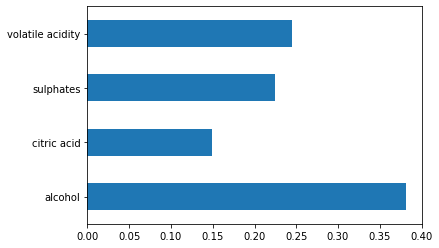

In [54]:
feature_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names())
feature_importances.plot(kind='barh')
plt.show

C:\Users\sasco\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

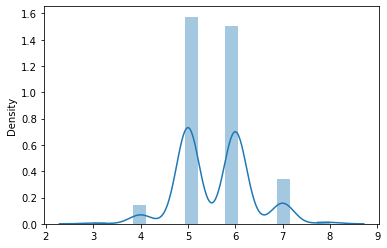

In [55]:
sns.distplot(y_test)

C:\Users\sasco\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

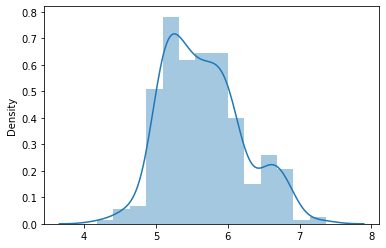

In [56]:
sns.distplot(y_pred_val)

In [57]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)

        scores.append((d, n, rmse))
    
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])
df_scores    

,max_depth,n_estimators,rmse
0,5,10,0.670036
1,5,20,0.655932
2,5,30,0.653800
3,5,40,0.654436
4,5,50,0.651962
5,5,60,0.652138
6,5,70,0.651483
7,5,80,0.650082
8,5,90,0.650600
9,5,100,0.649417


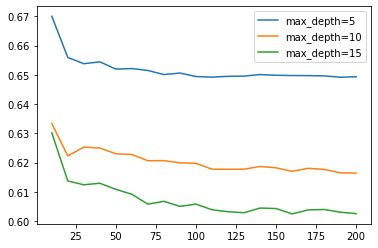

In [58]:
colors = ['blue', 'orange', 'red']
values = [5, 10, 15]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % s)

plt.legend()

In [59]:
rf_parameters = {
    'n_estimators': [10, 201, 501],
    'max_depth': [1,3,5,7,9,11,12],
    'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200]}


In [60]:
tuning_model = GridSearchCV(rf, param_grid=rf_parameters, scoring='neg_mean_squared_error', cv=5, verbose=4)

In [ ]:
tuning_model.fit(X_train, y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV 1/5] END max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   7.7s
[CV 2/5] END max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=1, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=1, min_samples_leaf=1, n_estimators=201; total time=   0.8s
[CV 2/5] END max_depth=1, min_samples_leaf=1, n_estimators=201; total time=   0.7s
[CV 3/5] END max_depth=1, min_samples_leaf=1, n_estimators=201; total time=   0.9s
[CV 4/5] END max_depth=1, min_samples_leaf=1, n_estimators=201; total time=   0.7s
[CV 5/5] END max_depth=1, min_samples_leaf=1, n_estimators=201; total time=   1.0s
[CV 1/5] END max_depth=1, min_samples_leaf=1, n_estimators=501; total time=   2.9s
[CV 2/5] END max_depth=1, min

[CV 4/5] END max_depth=1, min_samples_leaf=100, n_estimators=201; total time=   0.7s
[CV 5/5] END max_depth=1, min_samples_leaf=100, n_estimators=201; total time=   0.8s
[CV 1/5] END max_depth=1, min_samples_leaf=100, n_estimators=501; total time=   1.8s
[CV 2/5] END max_depth=1, min_samples_leaf=100, n_estimators=501; total time=   1.7s
[CV 3/5] END max_depth=1, min_samples_leaf=100, n_estimators=501; total time=   1.5s
[CV 4/5] END max_depth=1, min_samples_leaf=100, n_estimators=501; total time=   1.7s
[CV 5/5] END max_depth=1, min_samples_leaf=100, n_estimators=501; total time=   1.5s
[CV 1/5] END max_depth=1, min_samples_leaf=200, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=1, min_samples_leaf=200, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=1, min_samples_leaf=200, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=1, min_samples_leaf=200, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=1, min_samples_leaf=200, n_estimators=10; tota

[CV 2/5] END max_depth=3, min_samples_leaf=500, n_estimators=10; total time=   0.1s
[CV 3/5] END max_depth=3, min_samples_leaf=500, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=3, min_samples_leaf=500, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=3, min_samples_leaf=500, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=3, min_samples_leaf=500, n_estimators=201; total time=   0.6s
[CV 2/5] END max_depth=3, min_samples_leaf=500, n_estimators=201; total time=   0.6s
[CV 3/5] END max_depth=3, min_samples_leaf=500, n_estimators=201; total time=   0.7s
[CV 4/5] END max_depth=3, min_samples_leaf=500, n_estimators=201; total time=   0.6s
[CV 5/5] END max_depth=3, min_samples_leaf=500, n_estimators=201; total time=   0.6s
[CV 1/5] END max_depth=3, min_samples_leaf=500, n_estimators=501; total time=   1.8s
[CV 2/5] END max_depth=3, min_samples_leaf=500, n_estimators=501; total time=   1.6s
[CV 3/5] END max_depth=3, min_samples_leaf=500, n_estimators=501; tot

[CV 5/5] END max_depth=5, min_samples_leaf=15, n_estimators=201; total time=   1.2s
[CV 1/5] END max_depth=5, min_samples_leaf=15, n_estimators=501; total time=   2.7s
[CV 2/5] END max_depth=5, min_samples_leaf=15, n_estimators=501; total time=   2.4s
[CV 3/5] END max_depth=5, min_samples_leaf=15, n_estimators=501; total time=   1.8s
[CV 4/5] END max_depth=5, min_samples_leaf=15, n_estimators=501; total time=   1.9s
[CV 5/5] END max_depth=5, min_samples_leaf=15, n_estimators=501; total time=   1.8s
[CV 1/5] END max_depth=5, min_samples_leaf=20, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=20, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=20, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=20, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=20, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=20, n_estimators=201; total time=   0.

[CV 3/5] END max_depth=7, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=10, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=10, n_estimators=201; total time=   0.6s
[CV 2/5] END max_depth=7, min_samples_leaf=10, n_estimators=201; total time=   0.6s
[CV 3/5] END max_depth=7, min_samples_leaf=10, n_estimators=201; total time=   0.6s
[CV 4/5] END max_depth=7, min_samples_leaf=10, n_estimators=201; total time=   0.7s
[CV 5/5] END max_depth=7, min_samples_leaf=10, n_estimators=201; total time=   0.7s
[CV 1/5] END max_depth=7, min_samples_leaf=10, n_estimators=501; total time=   1.8s
[CV 2/5] END max_depth=7, min_samples_leaf=10, n_estimators=501; total time=   1.7s
[CV 3/5] END max_depth=7, min_samples_leaf=10, n_estimators=501; total time=   1.6s
[CV 4/5] END max_depth=7, min_samples_leaf=10, n_estimators=501; total time=   

[CV 1/5] END max_depth=9, min_samples_leaf=1, n_estimators=501; total time=   1.7s
[CV 2/5] END max_depth=9, min_samples_leaf=1, n_estimators=501; total time=   1.7s
[CV 3/5] END max_depth=9, min_samples_leaf=1, n_estimators=501; total time=   1.9s
[CV 4/5] END max_depth=9, min_samples_leaf=1, n_estimators=501; total time=   1.8s
[CV 5/5] END max_depth=9, min_samples_leaf=1, n_estimators=501; total time=   2.4s
[CV 1/5] END max_depth=9, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=9, min_samples_leaf=5, n_estimators=10; total time=   0.1s
[CV 5/5] END max_depth=9, min_samples_leaf=5, n_estimators=10; total time=   0.1s
[CV 1/5] END max_depth=9, min_samples_leaf=5, n_estimators=201; total time=   0.9s
[CV 2/5] END max_depth=9, min_samples_leaf=5, n_estimators=201; total time=   0.8s
[CV 3/5] 

[CV 1/5] END max_depth=9, min_samples_leaf=200, n_estimators=201; total time=   0.6s
[CV 2/5] END max_depth=9, min_samples_leaf=200, n_estimators=201; total time=   0.6s
[CV 3/5] END max_depth=9, min_samples_leaf=200, n_estimators=201; total time=   0.6s
[CV 4/5] END max_depth=9, min_samples_leaf=200, n_estimators=201; total time=   0.6s
[CV 5/5] END max_depth=9, min_samples_leaf=200, n_estimators=201; total time=   0.6s
[CV 1/5] END max_depth=9, min_samples_leaf=200, n_estimators=501; total time=   1.4s
[CV 2/5] END max_depth=9, min_samples_leaf=200, n_estimators=501; total time=   1.5s
[CV 3/5] END max_depth=9, min_samples_leaf=200, n_estimators=501; total time=   1.7s
[CV 4/5] END max_depth=9, min_samples_leaf=200, n_estimators=501; total time=   1.6s
[CV 5/5] END max_depth=9, min_samples_leaf=200, n_estimators=501; total time=   1.4s
[CV 1/5] END max_depth=11, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=1, n_estimators=10; tot

[CV 3/5] END max_depth=11, min_samples_leaf=500, n_estimators=501; total time=   1.3s
[CV 4/5] END max_depth=11, min_samples_leaf=500, n_estimators=501; total time=   1.3s
[CV 5/5] END max_depth=11, min_samples_leaf=500, n_estimators=501; total time=   1.5s
[CV 1/5] END max_depth=11, min_samples_leaf=100, n_estimators=10; total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=100, n_estimators=10; total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=100, n_estimators=10; total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=100, n_estimators=10; total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=100, n_estimators=10; total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=100, n_estimators=201; total time=   0.7s
[CV 2/5] END max_depth=11, min_samples_leaf=100, n_estimators=201; total time=   0.7s
[CV 3/5] END max_depth=11, min_samples_leaf=100, n_estimators=201; total time=   0.7s
[CV 4/5] END max_depth=11, min_samples_leaf=100, n_estimato

In [ ]:
print(tuning_model.best_estimator_)

In [ ]:
tuning_model.best_params_

In [ ]:
rf = RandomForestRegressor(n_estimators=501, max_depth=7, min_samples_leaf=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(rf.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

### XGBoost

In [ ]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

In [ ]:
feature_importances = pd.Series(xgbr.feature_importances_, index=dv.get_feature_names())
feature_importances.plot(kind='barh')
plt.show

In [ ]:
sns.distplot(y_test)

In [ ]:
sns.distplot(y_pred)

In [ ]:
for d in [0.3, 0.1, 0.01]:
    xgbr = XGBRegressor(eta=d, max_depth=5, min_child_weight=1, objective='reg:squarederror', nthread=8)
    xgbr.fit(X_train, y_train)

    y_pred = xgbr.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    print("ETA: {:.5}".format(d))
    print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
    print("RMSE: {:.5}".format(np.sqrt(mse)))
    print()

In [ ]:
xgbr_parameters = {
    'eta': [0.001, 0.01, 0.1, 0.3], 
    'max_depth': [1,2,3,4,5,6],
    'min_child_weight': [1,2,3,4,5,6],    
    'objective': ['reg:squarederror']
}


In [ ]:
tuning_model = GridSearchCV(xgbr, param_grid=xgbr_parameters, scoring='neg_mean_squared_error', cv=5, verbose=4)

In [ ]:
tuning_model.fit(X_train, y_train)

In [ ]:
print(tuning_model.best_estimator_)

In [ ]:
tuning_model.best_params_

In [ ]:
xgbr = XGBRegressor(eta=0.001, max_depth=5, min_child_weight=1, objective='reg:squarederror')
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

In [ ]:
xgbr = XGBRegressor(eta=0.1, max_depth=5, min_child_weight=1, objective='reg:squarederror')
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

### Random Forrest Regressor is the best model for this data!

## Validate the Model

In [ ]:
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_full_train, y_full_train)

y_pred_val = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_val)

print("MSE: {:.5}".format(mse))
print("Score: {:.5}".format(rf.score(X_test, y_test)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

## Save the Model

In [ ]:
output_file = 'model_rf.bin'

In [ ]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, rf), f_out)